<a href="https://colab.research.google.com/github/ben900926/Plant-seedling-classification/blob/main/Plant_github.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import os
import sys
import torch
import torchvision
import torch.nn as nn
from glob import glob
from torchvision import models
import torch.utils.data as data 
from torchvision import transforms
from torchvision.datasets.folder import DatasetFolder
from PIL import Image
from tqdm import tqdm
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import seaborn as sns
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import confusion_matrix

In [24]:
from google.colab import drive 
drive.mount('/content/drive')
root = '/content/drive/MyDrive/AI_FinalProject/plant-seedlings-classification-dataset/train'

batch_size = 64
num_workers = 2
num_epochs = 50

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
test_paths = glob('/content/drive/MyDrive/AI_FinalProject/plant-seedlings-classification-dataset/test/*.png')

In [26]:
train_paths = []
val_paths = []
train_labels = []
val_labels = []

In [27]:
class_paths = glob(root + '/*')
classes = [path.split("/")[-1] for path in class_paths]
nPics = {}

for i, cpath in enumerate(class_paths):
    img_class = cpath.split("/")[-1]
    nPics[img_class] = len(os.listdir(cpath))
    paths = glob(cpath + '/*.png')
    train_split = int(len(paths) * 0.9)
    
    train_paths.extend(paths[:train_split])
    train_labels.extend([i] * train_split)
    
    val_paths.extend(paths[train_split:])
    val_labels.extend([i] *(len(paths) - train_split))

In [28]:
print(f"Train Data: {len(train_paths)}")
print(f"Val Data: {len(val_paths)}")
print(f"Test Data: {len(test_paths)}")
print(f"Train Label: {len(train_labels)}")
print(f"Val Label: {len(val_labels)}")

Train Data: 4274
Val Data: 483
Test Data: 794
Train Label: 4274
Val Label: 483


In [29]:
# VGG Baseline
class VGG(nn.Module):
    def __init__(self, num_classes):
        super(VGG, self).__init__()
        self.model = models.vgg11(pretrained=True)
        self.model.classifier[6] = nn.Linear(in_features=4096, out_features=num_classes)

    def forward(self, x):
        return self.model(x)
    
# ResNet Baseline, Resnet18, Resnet34
class ResNet(nn.Module):
    def __init__(self, num_classes):
        super(ResNet, self).__init__()
        self.model = models.resnet34(pretrained=True)
        self.model.fc = nn.Linear(in_features=512, out_features=num_classes)

        for module in ['conv1', 'bn1', 'layer1']:
            for param in getattr(self.model, module).parameters():
                param.requires_grad = False
    def forward(self, x):
        return self.model(x)
             
#Densenet Baseline, Densenet 121
class Densenet(nn.Module): 
    def __init__(self, num_classes):
        super(Densenet, self).__init__()
        self.model = models.densenet121(pretrained=True)
        self.model.classifier = nn.Linear(1024, num_classes)

    def forward(self, x):
        return self.model(x)

In [30]:
model = VGG(num_classes=12)
#print(model)

Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /root/.cache/torch/hub/checkpoints/vgg11-8a719046.pth


  0%|          | 0.00/507M [00:00<?, ?B/s]

In [31]:
class Dataset(data.Dataset):

    def __init__(self, img_paths, img_labels=None, transform=None):
        self.transform = transform
        self.img_paths = img_paths
        self.img_labels = img_labels

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        img = Image.open(img_path).convert('RGB')
        
        if self.transform:
            img = self.transform(img)
            
        if self.img_labels is not None:
            label = self.img_labels[idx]
            return img, label
        else:
            return img, idx

    def __len__(self):
        return len(self.img_paths)

# Data augmentation and normalization for training
transform_options = [
    transforms.ColorJitter(brightness=0.5, contrast=0.5, hue=0.5),
    transforms.RandomRotation(degrees=[-15, 15]),
    transforms.GaussianBlur(kernel_size=3),
    transforms.RandomAffine(0, shear=20),
]
    
train_transforms = transforms.Compose([transforms.Resize((256, 256)),
                                       transforms.RandomRotation(degrees=(-8, 8)),
                                       transforms.RandomCrop((224, 224)),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomApply([
                                          transforms.RandomChoice(transform_options)
                                      ], p=0.9),
                                       transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])])

val_transforms = transforms.Compose([transforms.Resize((224, 224)),
                                     transforms.CenterCrop((224, 224)),
                                     transforms.ToTensor(), 
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])])



In [32]:
train_dataset = Dataset(train_paths, train_labels, transform=train_transforms)
val_dataset = Dataset(val_paths, val_labels, transform=val_transforms)
test_dataset = Dataset(test_paths,transform=val_transforms)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           num_workers=num_workers,
                                           shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                         batch_size=batch_size,
                                         num_workers=num_workers,
                                         shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                         batch_size=batch_size,
                                         num_workers=num_workers,
                                         shuffle=False)

In [33]:
def my_plot(epochs, loss):
    plt.plot(epochs, loss)

In [34]:
criterion = CrossEntropyLoss()
model = model.cuda()
optimizer = Adam(model.parameters(), lr=1e-4)

In [35]:
best_acc = 0.0
best_model_wts = copy.deepcopy(model.state_dict())
train_loss_vals=  []
train_acc_vals=  []
val_loss_vals = []
val_acc_vals = []
for epoch in range(num_epochs):
    train_epoch_loss= []
    # train phase
    model.train()
    train_loss = 0.0
    correct = 0.0
    steps = len(train_loader.dataset) // batch_size + 1
    with tqdm(total=steps) as progress_bar:
        
        for i, (x, y) in enumerate(train_loader):
            x, y = x.cuda(), y.cuda()

            optimizer.zero_grad() 
            
            y_pred = model(x)
            
            loss = criterion(y_pred, y)
            
            loss.backward()

            train_epoch_loss.append(loss.item())
            
            optimizer.step()
            
            progress_bar.set_postfix(loss=loss.item())
            progress_bar.update(1)
            
            correct += torch.sum(torch.argmax(y_pred, dim=-1) == y)

        train_loss_vals.append(sum(train_epoch_loss)/len(train_epoch_loss))
        train_acc = float(correct.item()) / float(len(train_loader.dataset))
        train_acc_vals.append(train_acc)
        print("Epoch %d: train correct: %.4f" % (epoch, train_acc))
        
    # val phase
    steps = len(val_loader.dataset) // batch_size + 1
    correct = 0.
    model.eval()
    val_epoch_loss = []
    with tqdm(total=steps) as progress_bar:
        for i, (x, y) in enumerate(val_loader):
            x, y = x.cuda(), y.cuda()
            
            y_pred = model(x)
            
            loss = criterion(y_pred, y)
            val_epoch_loss.append(loss.item())
            progress_bar.set_postfix(loss=loss.item())
            progress_bar.update(1)
            
            correct += torch.sum(torch.argmax(y_pred, dim=-1) == y)

        val_acc = float(correct.item()) / float(len(val_loader.dataset))
        val_acc_vals.append(val_acc)
        val_loss_vals.append(sum(val_epoch_loss)/len(val_epoch_loss))
        print("Epoch %d: val correct: %.4f" % (epoch, val_acc))

        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            best_epoch = epoch
          
        if epoch == num_epochs-1:


            trained_model_wts = copy.deepcopy(model.state_dict())
            model_save_name = 'VGG_val0.1' # DBG
            torch.save(trained_model_wts, os.path.join('/content/drive/MyDrive/AI_FinalProject', model_save_name))

model_save_name = 'VGG_val0.1_e' + str(best_epoch)
torch.save(best_model_wts, os.path.join('/content/drive/MyDrive/AI_FinalProject', model_save_name))


100%|██████████| 67/67 [01:09<00:00,  1.04s/it, loss=0.653]


Epoch 0: train correct: 0.5147


100%|██████████| 8/8 [00:07<00:00,  1.11it/s, loss=0.52]


Epoch 0: val correct: 0.8116


100%|██████████| 67/67 [01:08<00:00,  1.03s/it, loss=0.477]


Epoch 1: train correct: 0.8142


100%|██████████| 8/8 [00:07<00:00,  1.09it/s, loss=0.0824]


Epoch 1: val correct: 0.8820


100%|██████████| 67/67 [01:10<00:00,  1.05s/it, loss=0.481]


Epoch 2: train correct: 0.8793


100%|██████████| 8/8 [00:07<00:00,  1.11it/s, loss=0.0279]


Epoch 2: val correct: 0.9255


100%|██████████| 67/67 [01:08<00:00,  1.02s/it, loss=0.491]


Epoch 3: train correct: 0.9006


100%|██████████| 8/8 [00:07<00:00,  1.11it/s, loss=0.0254]


Epoch 3: val correct: 0.9027


100%|██████████| 67/67 [01:08<00:00,  1.01s/it, loss=0.224]


Epoch 4: train correct: 0.9106


100%|██████████| 8/8 [00:07<00:00,  1.11it/s, loss=0.0383]


Epoch 4: val correct: 0.9255


100%|██████████| 67/67 [01:08<00:00,  1.03s/it, loss=0.134]


Epoch 5: train correct: 0.9207


100%|██████████| 8/8 [00:07<00:00,  1.11it/s, loss=0.0208]


Epoch 5: val correct: 0.9358


100%|██████████| 67/67 [01:09<00:00,  1.04s/it, loss=0.251]


Epoch 6: train correct: 0.9343


100%|██████████| 8/8 [00:07<00:00,  1.10it/s, loss=0.0201]


Epoch 6: val correct: 0.9524


100%|██████████| 67/67 [01:08<00:00,  1.03s/it, loss=0.143]


Epoch 7: train correct: 0.9422


100%|██████████| 8/8 [00:07<00:00,  1.11it/s, loss=0.0994]


Epoch 7: val correct: 0.9296


100%|██████████| 67/67 [01:07<00:00,  1.01s/it, loss=0.101]


Epoch 8: train correct: 0.9506


100%|██████████| 8/8 [00:07<00:00,  1.11it/s, loss=0.0208]


Epoch 8: val correct: 0.9400


100%|██████████| 67/67 [01:09<00:00,  1.03s/it, loss=0.0713]


Epoch 9: train correct: 0.9572


100%|██████████| 8/8 [00:07<00:00,  1.11it/s, loss=0.0127]


Epoch 9: val correct: 0.9503


100%|██████████| 67/67 [01:07<00:00,  1.01s/it, loss=0.197]


Epoch 10: train correct: 0.9523


100%|██████████| 8/8 [00:07<00:00,  1.10it/s, loss=0.0494]


Epoch 10: val correct: 0.9317


100%|██████████| 67/67 [01:07<00:00,  1.00s/it, loss=0.0208]


Epoch 11: train correct: 0.9642


100%|██████████| 8/8 [00:07<00:00,  1.12it/s, loss=0.0922]


Epoch 11: val correct: 0.9420


100%|██████████| 67/67 [01:07<00:00,  1.01s/it, loss=0.282]


Epoch 12: train correct: 0.9640


100%|██████████| 8/8 [00:07<00:00,  1.12it/s, loss=0.0083]


Epoch 12: val correct: 0.9545


100%|██████████| 67/67 [01:08<00:00,  1.03s/it, loss=0.0762]


Epoch 13: train correct: 0.9661


100%|██████████| 8/8 [00:07<00:00,  1.11it/s, loss=0.21]


Epoch 13: val correct: 0.9462


100%|██████████| 67/67 [01:07<00:00,  1.01s/it, loss=0.117]


Epoch 14: train correct: 0.9654


100%|██████████| 8/8 [00:07<00:00,  1.11it/s, loss=0.0221]


Epoch 14: val correct: 0.9441


100%|██████████| 67/67 [01:07<00:00,  1.01s/it, loss=0.0623]


Epoch 15: train correct: 0.9736


100%|██████████| 8/8 [00:07<00:00,  1.12it/s, loss=0.0194]


Epoch 15: val correct: 0.9441


100%|██████████| 67/67 [01:07<00:00,  1.01s/it, loss=0.0307]


Epoch 16: train correct: 0.9698


100%|██████████| 8/8 [00:07<00:00,  1.12it/s, loss=0.00966]


Epoch 16: val correct: 0.9420


100%|██████████| 67/67 [01:08<00:00,  1.03s/it, loss=0.0731]


Epoch 17: train correct: 0.9614


100%|██████████| 8/8 [00:07<00:00,  1.12it/s, loss=0.00468]


Epoch 17: val correct: 0.9586


100%|██████████| 67/67 [01:07<00:00,  1.00s/it, loss=0.0448]


Epoch 18: train correct: 0.9764


100%|██████████| 8/8 [00:07<00:00,  1.11it/s, loss=0.00817]


Epoch 18: val correct: 0.9482


100%|██████████| 67/67 [01:07<00:00,  1.01s/it, loss=0.00519]


Epoch 19: train correct: 0.9796


100%|██████████| 8/8 [00:07<00:00,  1.12it/s, loss=0.0566]


Epoch 19: val correct: 0.9586


100%|██████████| 67/67 [01:08<00:00,  1.02s/it, loss=0.0608]


Epoch 20: train correct: 0.9789


100%|██████████| 8/8 [00:07<00:00,  1.13it/s, loss=0.00926]


Epoch 20: val correct: 0.9379


100%|██████████| 67/67 [01:07<00:00,  1.01s/it, loss=0.0144]


Epoch 21: train correct: 0.9724


100%|██████████| 8/8 [00:07<00:00,  1.11it/s, loss=0.00428]


Epoch 21: val correct: 0.9545


100%|██████████| 67/67 [01:08<00:00,  1.02s/it, loss=0.0328]


Epoch 22: train correct: 0.9792


100%|██████████| 8/8 [00:07<00:00,  1.12it/s, loss=0.0186]


Epoch 22: val correct: 0.9482


100%|██████████| 67/67 [01:07<00:00,  1.01s/it, loss=0.0892]


Epoch 23: train correct: 0.9850


100%|██████████| 8/8 [00:07<00:00,  1.09it/s, loss=0.00239]


Epoch 23: val correct: 0.9565


100%|██████████| 67/67 [01:08<00:00,  1.03s/it, loss=0.235]


Epoch 24: train correct: 0.9862


100%|██████████| 8/8 [00:07<00:00,  1.11it/s, loss=0.000352]


Epoch 24: val correct: 0.9669


100%|██████████| 67/67 [01:07<00:00,  1.01s/it, loss=0.0528]


Epoch 25: train correct: 0.9860


100%|██████████| 8/8 [00:07<00:00,  1.11it/s, loss=0.0111]


Epoch 25: val correct: 0.9503


100%|██████████| 67/67 [01:07<00:00,  1.01s/it, loss=0.0616]


Epoch 26: train correct: 0.9813


100%|██████████| 8/8 [00:07<00:00,  1.11it/s, loss=0.000796]


Epoch 26: val correct: 0.9586


100%|██████████| 67/67 [01:07<00:00,  1.00s/it, loss=0.0156]


Epoch 27: train correct: 0.9813


100%|██████████| 8/8 [00:08<00:00,  1.06s/it, loss=0.00701]


Epoch 27: val correct: 0.9586


100%|██████████| 67/67 [01:07<00:00,  1.01s/it, loss=0.027]


Epoch 28: train correct: 0.9836


100%|██████████| 8/8 [00:07<00:00,  1.11it/s, loss=0.000184]


Epoch 28: val correct: 0.9627


100%|██████████| 67/67 [01:07<00:00,  1.01s/it, loss=0.0518]


Epoch 29: train correct: 0.9867


100%|██████████| 8/8 [00:07<00:00,  1.11it/s, loss=0.00972]


Epoch 29: val correct: 0.9441


100%|██████████| 67/67 [01:07<00:00,  1.01s/it, loss=0.00146]


Epoch 30: train correct: 0.9860


100%|██████████| 8/8 [00:07<00:00,  1.11it/s, loss=0.0309]


Epoch 30: val correct: 0.9627


100%|██████████| 67/67 [01:08<00:00,  1.03s/it, loss=0.0267]


Epoch 31: train correct: 0.9881


100%|██████████| 8/8 [00:07<00:00,  1.11it/s, loss=0.00633]


Epoch 31: val correct: 0.9462


100%|██████████| 67/67 [01:07<00:00,  1.00s/it, loss=0.0205]


Epoch 32: train correct: 0.9853


100%|██████████| 8/8 [00:07<00:00,  1.12it/s, loss=0.000421]


Epoch 32: val correct: 0.9669


100%|██████████| 67/67 [01:07<00:00,  1.00s/it, loss=0.117]


Epoch 33: train correct: 0.9902


100%|██████████| 8/8 [00:07<00:00,  1.12it/s, loss=0.00492]


Epoch 33: val correct: 0.9441


100%|██████████| 67/67 [01:07<00:00,  1.00s/it, loss=0.0225]


Epoch 34: train correct: 0.9860


100%|██████████| 8/8 [00:07<00:00,  1.12it/s, loss=0.000421]


Epoch 34: val correct: 0.9545


100%|██████████| 67/67 [01:08<00:00,  1.03s/it, loss=0.097]


Epoch 35: train correct: 0.9897


100%|██████████| 8/8 [00:07<00:00,  1.11it/s, loss=0.00795]


Epoch 35: val correct: 0.9586


100%|██████████| 67/67 [01:08<00:00,  1.02s/it, loss=0.00417]


Epoch 36: train correct: 0.9899


100%|██████████| 8/8 [00:07<00:00,  1.12it/s, loss=0.00538]


Epoch 36: val correct: 0.9586


100%|██████████| 67/67 [01:07<00:00,  1.00s/it, loss=0.00333]


Epoch 37: train correct: 0.9925


100%|██████████| 8/8 [00:07<00:00,  1.10it/s, loss=0.0354]


Epoch 37: val correct: 0.9482


100%|██████████| 67/67 [01:09<00:00,  1.03s/it, loss=0.00237]


Epoch 38: train correct: 0.9944


100%|██████████| 8/8 [00:07<00:00,  1.11it/s, loss=0.00927]


Epoch 38: val correct: 0.9689


100%|██████████| 67/67 [01:06<00:00,  1.00it/s, loss=0.0945]


Epoch 39: train correct: 0.9869


100%|██████████| 8/8 [00:07<00:00,  1.11it/s, loss=0.000719]


Epoch 39: val correct: 0.9545


100%|██████████| 67/67 [01:07<00:00,  1.01s/it, loss=0.0135]


Epoch 40: train correct: 0.9822


100%|██████████| 8/8 [00:07<00:00,  1.12it/s, loss=0.0105]


Epoch 40: val correct: 0.9462


100%|██████████| 67/67 [01:07<00:00,  1.01s/it, loss=0.0347]


Epoch 41: train correct: 0.9871


100%|██████████| 8/8 [00:07<00:00,  1.11it/s, loss=0.0225]


Epoch 41: val correct: 0.9524


100%|██████████| 67/67 [01:08<00:00,  1.02s/it, loss=0.00806]


Epoch 42: train correct: 0.9911


100%|██████████| 8/8 [00:07<00:00,  1.10it/s, loss=0.0345]


Epoch 42: val correct: 0.9524


100%|██████████| 67/67 [01:07<00:00,  1.00s/it, loss=0.00555]


Epoch 43: train correct: 0.9909


100%|██████████| 8/8 [00:07<00:00,  1.13it/s, loss=0.00595]


Epoch 43: val correct: 0.9607


100%|██████████| 67/67 [01:07<00:00,  1.00s/it, loss=0.00329]


Epoch 44: train correct: 0.9958


100%|██████████| 8/8 [00:07<00:00,  1.11it/s, loss=0.0403]


Epoch 44: val correct: 0.9400


100%|██████████| 67/67 [01:07<00:00,  1.01s/it, loss=0.0563]


Epoch 45: train correct: 0.9911


100%|██████████| 8/8 [00:07<00:00,  1.12it/s, loss=0.0341]


Epoch 45: val correct: 0.9524


100%|██████████| 67/67 [01:08<00:00,  1.03s/it, loss=0.311]


Epoch 46: train correct: 0.9874


100%|██████████| 8/8 [00:07<00:00,  1.12it/s, loss=0.403]


Epoch 46: val correct: 0.9524


100%|██████████| 67/67 [01:07<00:00,  1.00s/it, loss=0.017]


Epoch 47: train correct: 0.9904


100%|██████████| 8/8 [00:07<00:00,  1.12it/s, loss=0.00334]


Epoch 47: val correct: 0.9545


100%|██████████| 67/67 [01:07<00:00,  1.01s/it, loss=0.000199]


Epoch 48: train correct: 0.9927


100%|██████████| 8/8 [00:07<00:00,  1.12it/s, loss=2.25e-6]


Epoch 48: val correct: 0.9648


100%|██████████| 67/67 [01:09<00:00,  1.03s/it, loss=0.01]


Epoch 49: train correct: 0.9909


100%|██████████| 8/8 [00:07<00:00,  1.45it/s, loss=6.23e-5]

Epoch 49: val correct: 0.9545


100%|██████████| 8/8 [00:09<00:00,  1.24s/it, loss=6.23e-5]


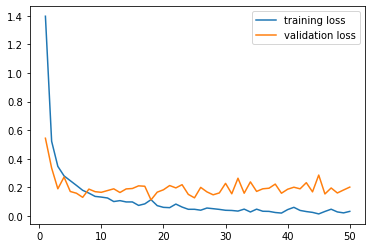

In [36]:
plt.plot(np.linspace(1, num_epochs, num_epochs).astype(int), train_loss_vals, label="training loss")
plt.plot(np.linspace(1, num_epochs, num_epochs).astype(int), val_loss_vals, label="validation loss")
plt.legend()
plt.show()

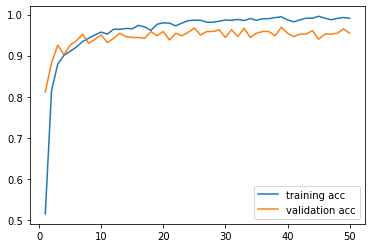

In [37]:
plt.plot(np.linspace(1, num_epochs, num_epochs).astype(int), train_acc_vals, label="training acc")
plt.plot(np.linspace(1, num_epochs, num_epochs).astype(int), val_acc_vals, label="validation acc")
plt.legend()
plt.show()

In [45]:
model = VGG(num_classes=12)
model.load_state_dict(torch.load('/content/drive/MyDrive/AI_FinalProject/VGG_val0.1_e38'))
model.cuda()

VGG(
  (model): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (12): ReLU(inplace=True)
      (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (14): ReLU(inplace=True)
      (15): MaxPool2d(kernel_size=2, s

In [46]:
test_label_indices = []
test_img_indices = []

for i, (x, img_idx) in enumerate(test_loader):
    x = x.cuda()
    y_pred = model(x)
    test_label_indices.extend(list(torch.argmax(y_pred, dim=-1).cpu().numpy()))
    test_img_indices.extend(list(img_idx.cpu().numpy()))
    
test_names = [test_paths[idx] for idx in test_img_indices]
test_names = [name.split("/")[-1] for name in test_names]
test_labels = [classes[idx] for idx in test_label_indices]

out_df = pd.DataFrame({'file': test_names,'species' : test_labels})
out_df.to_csv('/content/drive/MyDrive/AI_FinalProject/VGG_val0.1_e38.csv', index=False)

In [40]:
y_pred = []
y_true = []
model.eval()


with torch.no_grad():
    for i, (images, target) in enumerate(val_loader):
        target, images = target.cuda(), images.cuda()
        output = model(images)
        _, preds = torch.max(output, 1)
        loss = criterion(output, target)          
        y_pred.extend(preds.view(-1).detach().cpu().numpy())       
        y_true.extend(target.view(-1).detach().cpu().numpy())

In [41]:
cf_matrix = confusion_matrix(y_true, y_pred)
cf_matrix.diagonal()/cf_matrix.sum(axis=1)

array([0.93103448, 1.        , 0.96774194, 0.93939394, 0.94339623,
       0.95833333, 1.        , 1.        , 0.95652174, 0.66666667,
       1.        , 1.        ])

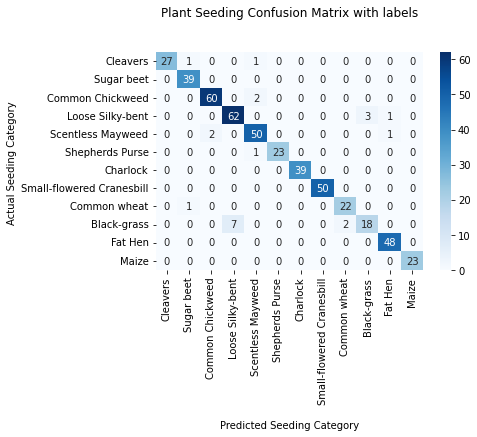

In [42]:
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Plant Seeding Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Seeding Category')
ax.set_ylabel('Actual Seeding Category ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(classes)
ax.yaxis.set_ticklabels(classes)

## Display the visualization of the Confusion Matrix.
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()